In [1]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing libraries for machine learning
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import dump,load
import shap

# Display setting for exploration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Check out if the environment is the correct Anaconda one
import sys
print('environment: ',sys.executable)

# Set up directory to be the github repository
# requires git
import os
import subprocess
os.getcwd()
output = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'])
path = output.decode('utf-8').strip()
print('working directory: ',path)
os.chdir(path)


environment:  c:\Users\ricca\Documents\Codice\Anaconda\envs\Thesis\python.exe
working directory:  C:/Users/ricca/Documents/Codice/Uni/Thesis-SEM-ML


In [3]:
from Source.DataPreparation.DataProcessor import DataProcessor
from Source.Regression.latent_variable_regressors import GBoostRegression, RFRegression, LinearRegressionModel, ElasticLinear

In [4]:
Results_RF = []
Results_XGB = []
Results_LM=[]
Results_ElasticNet=[]
shap_values_list_xgb = None
shap_values_list_ElasticNet = None
#shap_values_list_LM = None
#shap_values_list_RF = None

def store_and_print_results(model_name, results_dict, results_list, i):
    """Store results in the given list and print them."""
    metrics = (results_dict['mse'], results_dict['r2'], results_dict['mae'], results_dict['train_mse'], results_dict['train_r2'])
    results_list.append(metrics)
    
    print(f"Iteration {i+1} {model_name}: MSE: {metrics[0]}, R^2: {metrics[1]}, MAE: {metrics[2]}, TRAIN_MSE: {metrics[3]}, TRAIN_R^2: {metrics[4]}")


In [5]:
montecarloiter=15


for i in range(montecarloiter):
    print(f"Starting the iteration n.{i+1}")

    processorclass=DataProcessor()
    processorclass.read_df()
    processorclass.split_data(test_size=0.3)
    processorclass.save_data()
    try:
        processorclass.process_CFA()
    except Exception as e:
        print(f"Error during process_CFA for iteration n.{i+1}: {e}")
        continue    

    X_train,y_train,X_test,y_test = processorclass.train_test_data_for_WEtarget(target_variable='WorkEngagement')

    #X_train['WorkEngagement'] = y_train
    #X_test['WorkEngagement'] = y_train
    #y_train = X_train['WHO5']
    #y_test = X_test['WHO5']
    #X_train = X_train.drop('WHO5', axis=1)
    #X_test = X_test.drop('WHO5', axis=1)
    #display(X_train)
    #display(X_test)
    #display(y_train)
    #display(y_test)

    # XGBRegressor
    Xgboost=GBoostRegression(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
    Xgboost.train(verbosity=0,n_iter=60,cv=5)
    store_and_print_results('XGB',Xgboost.get_results(),Results_XGB,i)

    if shap_values_list_xgb is None:
        shap_values_list_xgb = Xgboost.get_shap_values()
    else:
        shap_values_list_xgb += Xgboost.get_shap_values()

    ## RandomForest
    RFRegre=RFRegression(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
    RFRegre.median_imputation()
    RFRegre.train(verbosity=0,n_iter=25,computeshap=False)
    store_and_print_results('RandomForest',RFRegre.get_results(),Results_RF,i)

    ## Linear Regression
    #LMreg= LinearRegressionModel(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
    #LMreg.median_imputation()
    #LMreg.train(computeshap=False)
    #store_and_print_results('LinearRegression',LMreg.get_results(),Results_LM,i)

    # ElasticLinear
    Elasticregr = ElasticLinear(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
    Elasticregr.median_imputation(standardscaling=False)
    Elasticregr.train(computeshap=True,verbosity=0,n_iter=80)
    store_and_print_results('ElasticNet',Elasticregr.get_results(),Results_ElasticNet,i)

    if shap_values_list_ElasticNet is None:
        shap_values_list_ElasticNet = Elasticregr.get_shap_values()
    else:
        shap_values_list_ElasticNet += Elasticregr.get_shap_values()

    print(("-------------------------------------------------"))


shap_values_list_xgb /= montecarloiter
shap_values_list_ElasticNet /= montecarloiter
#shap_values_list_LM /= montecarloiter
#shap_values_list_RF /= montecarloiter

Starting the iteration n.1
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the XGBRegressor training
Iteration 1 XGB: MSE: 0.06112651008153651, R^2: 0.8470653845340973, MAE: 0.19214908340486977, TRAIN_MSE: 0.03346524754762721, TRAIN_R^2: 0.926570404743295
Starting the Random Forest training with median imputation


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Iteration 1 RandomForest: MSE: 0.06746497621468166, R^2: 0.8312069479993899, MAE: 0.20139607245523958, TRAIN_MSE: 0.030541607937061472, TRAIN_R^2: 0.9329854678016148
Iteration 1 ElasticNet: MSE: 0.05343531445097214, R^2: 0.8663082636820217, MAE: 0.18037238813335024, TRAIN_MSE: 0.09335570496921068, TRAIN_R^2: 0.7951584962568266
-------------------------------------------------
Starting the iteration n.2
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the XGBRegressor training
Iteration 2 XGB: MSE: 0.09862145542281119, R^2: 0.796459815057908, MAE: 0.2517005422248347, TRAIN_MSE: 0.03407027668963861, TRAIN_R^2: 0.9184269733671397
Starting the Random Forest training with median imputation
Iteration 2 RandomForest: MSE: 0.11318533527083256, R^2: 0.7664021081924806, MAE: 0.2683485451182293, TRAIN_MSE: 0.026086270861843838, TRAIN_R^2: 0.9375427418113003
Iteration 2 ElasticNet: MSE: 0.10021816609739599, R^2: 0.79316

The objective has been evaluated at this point before.


Iteration 5 RandomForest: MSE: 0.10164729858038747, R^2: 0.7640719513805077, MAE: 0.24857091999894446, TRAIN_MSE: 0.026030352363208702, TRAIN_R^2: 0.9417919098227626
Iteration 5 ElasticNet: MSE: 0.0982632302550241, R^2: 0.7719265293924025, MAE: 0.24176541646971594, TRAIN_MSE: 0.07540172438823158, TRAIN_R^2: 0.8313895136159286
-------------------------------------------------
Starting the iteration n.6
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the XGBRegressor training
Iteration 6 XGB: MSE: 0.06951476310240165, R^2: 0.8427168339043116, MAE: 0.20416397519088436, TRAIN_MSE: 0.04520945587932857, TRAIN_R^2: 0.8969855579492207
Starting the Random Forest training with median imputation


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Iteration 6 RandomForest: MSE: 0.0817349182949639, R^2: 0.8150676754653259, MAE: 0.22120584753011688, TRAIN_MSE: 0.030184779601416432, TRAIN_R^2: 0.9312208437684953
Iteration 6 ElasticNet: MSE: 0.06363527143027047, R^2: 0.8560196925195929, MAE: 0.19490632145814468, TRAIN_MSE: 0.09181419943295115, TRAIN_R^2: 0.7907918079755287
-------------------------------------------------
Starting the iteration n.7
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the XGBRegressor training
Iteration 7 XGB: MSE: 0.06256575872744691, R^2: 0.844286892595703, MAE: 0.19560684035999004, TRAIN_MSE: 0.06909978170540204, TRAIN_R^2: 0.8480345394388973
Starting the Random Forest training with median imputation


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Iteration 7 RandomForest: MSE: 0.07263625264169936, R^2: 0.8192235363385624, MAE: 0.21107363009867444, TRAIN_MSE: 0.02162728765237806, TRAIN_R^2: 0.9524368869529418
Iteration 7 ElasticNet: MSE: 0.05309237536502259, R^2: 0.867864165388339, MAE: 0.1797384368297576, TRAIN_MSE: 0.09482949682807253, TRAIN_R^2: 0.7914492954305661
-------------------------------------------------
Starting the iteration n.8
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the XGBRegressor training
Iteration 8 XGB: MSE: 0.15738144483953895, R^2: 0.6323518408324535, MAE: 0.30344709355292554, TRAIN_MSE: 0.03277389089837338, TRAIN_R^2: 0.92594063999964
Starting the Random Forest training with median imputation


The objective has been evaluated at this point before.


Iteration 8 RandomForest: MSE: 0.1639724266832834, R^2: 0.6169550934939732, MAE: 0.31304037975733295, TRAIN_MSE: 0.030198912065347666, TRAIN_R^2: 0.9317593352830195
Iteration 8 ElasticNet: MSE: 0.16706153760213582, R^2: 0.6097388302048771, MAE: 0.31701675643731836, TRAIN_MSE: 0.06423247894552249, TRAIN_R^2: 0.8548534778280449
-------------------------------------------------
Starting the iteration n.9
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the XGBRegressor training
Iteration 9 XGB: MSE: 0.10961524781075385, R^2: 0.7537279807425712, MAE: 0.2622015971960197, TRAIN_MSE: 0.047465695151254234, TRAIN_R^2: 0.8918925480944664
Starting the Random Forest training with median imputation
Iteration 9 RandomForest: MSE: 0.12047298953846967, R^2: 0.7293339476745012, MAE: 0.2764963685577381, TRAIN_MSE: 0.016164023051923233, TRAIN_R^2: 0.9631849625478507
Iteration 9 ElasticNet: MSE: 0.10158309545059176, R^2: 0.7717

The objective has been evaluated at this point before.


Iteration 10 RandomForest: MSE: 0.07758874757971015, R^2: 0.8212500553714007, MAE: 0.21453750304714397, TRAIN_MSE: 0.0317275159283133, TRAIN_R^2: 0.9292701865494603
Iteration 10 ElasticNet: MSE: 0.06498875531926111, R^2: 0.8502780779794756, MAE: 0.19006943432763077, TRAIN_MSE: 0.09153848780737968, TRAIN_R^2: 0.7959342237574076
-------------------------------------------------
Starting the iteration n.11
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the XGBRegressor training
Iteration 11 XGB: MSE: 0.13365338477074667, R^2: 0.6993962064078374, MAE: 0.2838603214192758, TRAIN_MSE: 0.03950009839954821, TRAIN_R^2: 0.9101601186929957
Starting the Random Forest training with median imputation


The objective has been evaluated at this point before.


Iteration 11 RandomForest: MSE: 0.13448583458064026, R^2: 0.6975239188390765, MAE: 0.2855428345672307, TRAIN_MSE: 0.023048137779198386, TRAIN_R^2: 0.9475788150832974
Iteration 11 ElasticNet: MSE: 0.13655883675517377, R^2: 0.692861468136025, MAE: 0.2849092111185234, TRAIN_MSE: 0.060928760327828, TRAIN_R^2: 0.8614223048088006
-------------------------------------------------
Starting the iteration n.12
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the XGBRegressor training
Iteration 12 XGB: MSE: 0.16453822985008695, R^2: 0.6678814476048882, MAE: 0.3223779430000491, TRAIN_MSE: 0.03529061337963346, TRAIN_R^2: 0.915205933984927
Starting the Random Forest training with median imputation
Iteration 12 RandomForest: MSE: 0.14968797126116581, R^2: 0.6978565262825865, MAE: 0.3097668724998798, TRAIN_MSE: 0.020795827857171382, TRAIN_R^2: 0.9500330929023542
Iteration 12 ElasticNet: MSE: 0.15060833892264014, R^2: 0.6959

The objective has been evaluated at this point before.


Iteration 13 RandomForest: MSE: 0.07955961248732567, R^2: 0.8186037064522041, MAE: 0.21819634146818834, TRAIN_MSE: 0.01910513169444342, TRAIN_R^2: 0.9564350879866425
Iteration 13 ElasticNet: MSE: 0.0650134692417941, R^2: 0.8517689819941769, MAE: 0.20210432975104867, TRAIN_MSE: 0.08421152891077407, TRAIN_R^2: 0.8079747417509194
-------------------------------------------------
Starting the iteration n.14
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the XGBRegressor training
Iteration 14 XGB: MSE: 0.09660374549792874, R^2: 0.7667614250746259, MAE: 0.2410734468273574, TRAIN_MSE: 0.05558306351604322, TRAIN_R^2: 0.8776268148028019
Starting the Random Forest training with median imputation


The objective has been evaluated at this point before.


Iteration 14 RandomForest: MSE: 0.09143709778918442, R^2: 0.7792356986394621, MAE: 0.23841847741373126, TRAIN_MSE: 0.02313198818271599, TRAIN_R^2: 0.9490719853351398
Iteration 14 ElasticNet: MSE: 0.08652705380989031, R^2: 0.7910904321660832, MAE: 0.22803479939482627, TRAIN_MSE: 0.08323484380310221, TRAIN_R^2: 0.8167479028456766
-------------------------------------------------
Starting the iteration n.15
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the XGBRegressor training
Iteration 15 XGB: MSE: 0.1277574067399929, R^2: 0.7530018123808169, MAE: 0.28009924940352326, TRAIN_MSE: 0.044290520528092216, TRAIN_R^2: 0.8914606910219713
Starting the Random Forest training with median imputation


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Iteration 15 RandomForest: MSE: 0.12183222439901815, R^2: 0.7644571897000547, MAE: 0.2766843167338485, TRAIN_MSE: 0.01767196428681226, TRAIN_R^2: 0.9566927015283461
Iteration 15 ElasticNet: MSE: 0.10659532869188588, R^2: 0.7939152518244956, MAE: 0.2564072356144091, TRAIN_MSE: 0.0757696545666249, TRAIN_R^2: 0.8143172432812307
-------------------------------------------------


In [6]:
import numpy as np

def compute_95_CI(results):
    std_error = np.std(results) / np.sqrt(len(results))
    ci_upper = np.mean(results) + 1.96 * std_error
    ci_lower = np.mean(results) - 1.96 * std_error
    return ci_lower, ci_upper

def print_avg_metrics(Results, model_name):
    mse_avg = np.mean([res[0] for res in Results])
    r2_avg = np.mean([res[1] for res in Results])
    mae_avg = np.mean([res[2] for res in Results])
    train_mse_avg = np.mean([res[3] for res in Results])
    train_r2_avg = np.mean([res[4] for res in Results])
    # Calculate CIs
    mse_ci = compute_95_CI([res[0] for res in Results])
    r2_ci = compute_95_CI([res[1] for res in Results])
    mae_ci = compute_95_CI([res[2] for res in Results])
    train_mse_ci = compute_95_CI([res[3] for res in Results])
    train_r2_ci = compute_95_CI([res[4] for res in Results])
    
    print(f"Model: {model_name}")
    print(f"Average MSE over {montecarloiter} iterations: {mse_avg:.2f} (95% CI: {mse_ci[0]:.2f} - {mse_ci[1]:.2f})")
    print(f"Average MAE over {montecarloiter} iterations: {mae_avg:.2f} (95% CI: {mae_ci[0]:.2f} - {mae_ci[1]:.2f})")
    print(f"Average R^2 over {montecarloiter} iterations: {r2_avg:.2f} (95% CI: {r2_ci[0]:.2f} - {r2_ci[1]:.2f})")
    print(f"Average Training MSE over {montecarloiter} iterations: {train_mse_avg:.2f} (95% CI: {train_mse_ci[0]:.2f} - {train_mse_ci[1]:.2f})")
    print(f"Average Training R^2 over {montecarloiter} iterations: {train_r2_avg:.2f} (95% CI: {train_r2_ci[0]:.2f} - {train_r2_ci[1]:.2f})")
    print("-------------------------------------------------")


# Print the metrics for each model
print_avg_metrics(Results_XGB, "XGBoost")
print_avg_metrics(Results_RF, "Random Forest")
#print_avg_metrics(Results_LM, "Linear Model")
print_avg_metrics(Results_ElasticNet, "Elastic Net")




Model: XGBoost
Average MSE over 15 iterations: 0.10 (95% CI: 0.09 - 0.12)
Average MAE over 15 iterations: 0.25 (95% CI: 0.23 - 0.27)
Average R^2 over 15 iterations: 0.77 (95% CI: 0.74 - 0.80)
Average Training MSE over 15 iterations: 0.04 (95% CI: 0.04 - 0.05)
Average Training R^2 over 15 iterations: 0.90 (95% CI: 0.89 - 0.92)
-------------------------------------------------
Model: Random Forest
Average MSE over 15 iterations: 0.11 (95% CI: 0.09 - 0.12)
Average MAE over 15 iterations: 0.25 (95% CI: 0.24 - 0.27)
Average R^2 over 15 iterations: 0.76 (95% CI: 0.73 - 0.79)
Average Training MSE over 15 iterations: 0.02 (95% CI: 0.02 - 0.03)
Average Training R^2 over 15 iterations: 0.94 (95% CI: 0.94 - 0.95)
-------------------------------------------------
Model: Elastic Net
Average MSE over 15 iterations: 0.10 (95% CI: 0.08 - 0.11)
Average MAE over 15 iterations: 0.24 (95% CI: 0.22 - 0.26)
Average R^2 over 15 iterations: 0.78 (95% CI: 0.75 - 0.82)
Average Training MSE over 15 iterations: 0

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


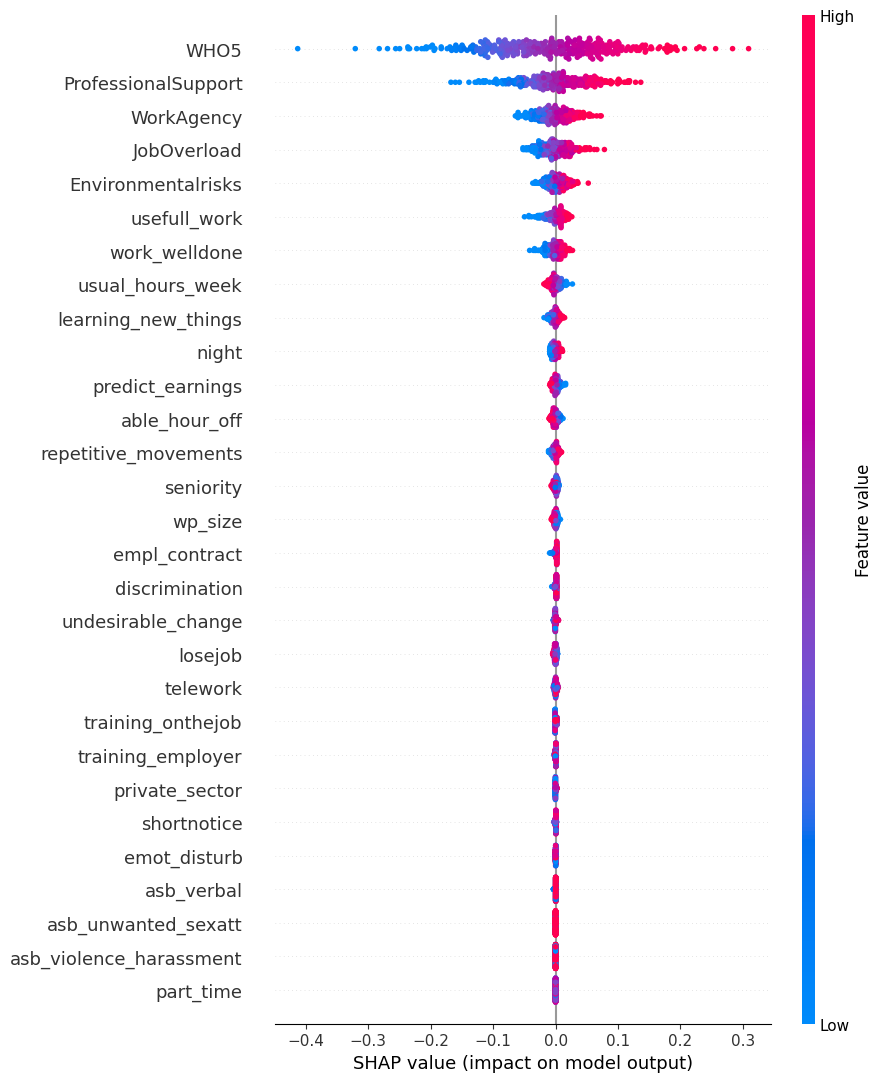

In [7]:
shap.plots.beeswarm(shap_values_list_ElasticNet, max_display=30)

In [8]:
#shap.waterfall_plot(shap_values_list_ElasticNet[2])


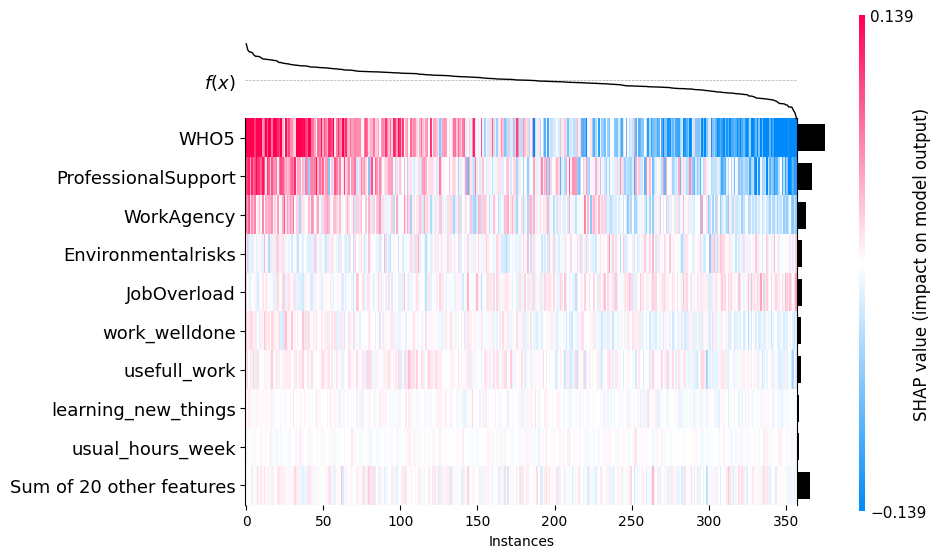

In [9]:
shap.plots.heatmap(shap_values_list_xgb, instance_order=shap_values_list_xgb.sum(1))

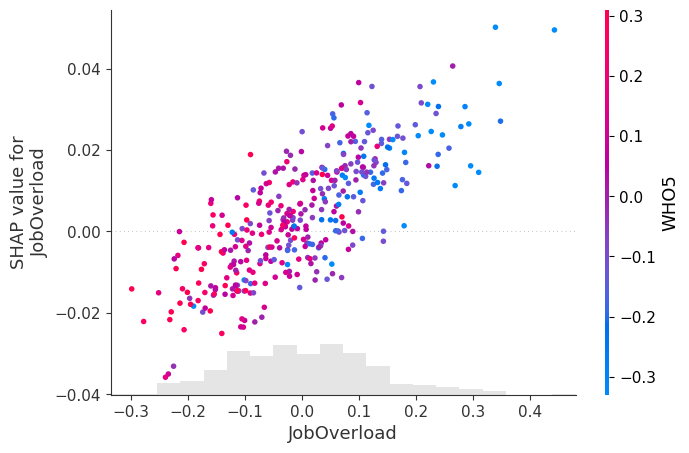

In [10]:
shap.plots.scatter(shap_values_list_xgb[:, "JobOverload"],color=shap_values_list_xgb[:, "WHO5"])
#color=plt.get_cmap("cool")
#color=shap_values[:,"Workclass"])
